# **Introduction to In-Context Learning Demo: Image Classification**

## **Overview**
This notebook presents a step-by-step walkthrough of an interactive demo that explores how Large Language Models (LLMs) can perform image-based image classification purely through in-context learning. Inspired by the idea that LLMs can function as general pattern recognizers, this experiment uses small image snippets of weld defects, labeled with their respective defect—to examine how effectively Gemini can internalize visual defect patterns and reproduce consistent judgments on new samples.

The goal is to illustrate how an LLM—without explicit training, fine-tuning, or feature engineering—can infer quality cues (defects) from a few examples and generalize to other images.

## **Background**
This demo focuses on real weld defect images categorized into 6 classes:
- Weld Cracks
- Burn Through
- Lack of Fusion
- Slag Inclusion
- Weld Splatter
- Surface Porosity

Each example image serves as an example pairing:
- A compact visual representation
- A category label from one of the 6 classes

What makes this setup particularly compelling:
- The data was checked before utilization to make sure it couldn't classify the industrial defect correctly before ICL.
- The model receives visual examples only through prompt context
- No training or gradient updates occur—classification arises from pattern matching
- Prompts can include descriptions, annotations, or multi-step chains of examples
- The test images require generalization, not memorization
- Predictions are generated sample-by-sample, mimicking standard evaluation flows

This setting provides a clear benchmark for understanding how well LLMs can perform visual classification tasks when guided only through carefully constructed prompts.

## **Let's Take a Look at an Example**

The illustration below shows an example of weld defects. Given a set of labeled samples in context, the LLM must detect the defect for new, unseen defect images during evaluation.

<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/weld_defects.png" height="500">

## **LLM as the Classifier**

In this demo, we use Gemini 2.0/2.5 Flash in non-reasoning mode, prompting the model to rely on direct pattern recognition rather than symbolic explanation or analytic reasoning.

The workflow proceeds as follows:
- Provide 9 total images of weld defects (1-2 for each defect) as in-context examples
- Send a new unlabeled image through the prompt to classify
- Ask the model to output the category of the new unlabeled image

The LLM functions as a lightweight, prompt-driven classifier—absorbing visual differences, structural patterns, and defect signatures from the in-context examples.

## **Evaluation**
Finally, we compare the model’s predicted labels against ground-truth labels and compute accuracy, which provides insight into how effectively a LLM can approximate visual quality-control decisions through in-context learning alone—without any dedicated training pipeline.

## **Code Overview**
The implementation is structured modularly, with each component handling a distinct stage of the ICL classification pipeline. This separation makes the system easy to modify, extend, and reuse:
- Data loading & preprocessing: Read images, convert to model-compatible format
- Visualization: Display sets of good/bad examples
- Prompt construction: Insert labeled samples into few-shot prompts
- LLM inference: Retrieve predictions one image at a time

## **Before Running the Demo, Follow the Instructions Below**
To run the full experiment:
1. Ensure all dependencies are imported and installed.
2.	Visit Google AI Studio (https://aistudio.google.com/) to obtain your Gemini API key.
3.	Once API key is generated, copy and paste it into the demo when prompted.

#### **If having trouble creating an API Key, follow the link below for instructions:**
* #### **[Instructions on How to Obtain a Gemini API Key](https://docs.google.com/document/d/17pgikIpvZCBgcRh4NNrcee-zp3Id0pU0vq2SG52KIGE/edit?usp=sharing)**



In [ ]:
#@title **Import Necessary Libraries**
import numpy as np
import matplotlib.pyplot as plt
from google import genai
from google.genai import types
import re
import itertools
import math
import ast
import json
import ipywidgets as widgets
from IPython.display import display
import os
import getpass
from IPython.display import Image
import time

In [ ]:
#@title **Setting Up Gemini Client**
apikey = getpass.getpass("Enter your Gemini API Key: ")
client = genai.Client(api_key=apikey)

Enter your Gemini API Key: ··········


In [ ]:
#@title **Choose a Model**
model_dropdown = widgets.Dropdown(
    options=[
        ("Gemini 2.5 Flash", "gemini-2.5-flash"),
        ("Gemini 2.0 Flash", "gemini-2.0-flash")
    ],
    description="Model:",
    value="gemini-2.5-flash",
    style={'description_width': 'initial'}
)

confirm_button = widgets.Button(
    description="Confirm Selection"
)

output = widgets.Output()

model_name = None

def on_confirm_click(b):
    global model_name, batch_size

    model_name = model_dropdown.value

    with output:
        output.clear_output()
        print(f"\nSelected model: {model_name}")

confirm_button.on_click(on_confirm_click)

display(model_dropdown, confirm_button, output)

Dropdown(description='Model:', options=(('Gemini 2.5 Flash', 'gemini-2.5-flash'), ('Gemini 2.0 Flash', 'gemini…

Button(description='Confirm Selection', style=ButtonStyle())

Output()

In [ ]:
#@title **Download Data from GitHub**
if not os.path.exists("intro_to_icl_data"):
    !git clone https://github.com/hsiang-fu/intro_to_icl_data.git

Cloning into 'intro_to_icl_data'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 172 (delta 63), reused 115 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (172/172), 17.23 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (63/63), done.


The cell `ICL Image Classification` below  is responsible for running ICL weld defect image classification. It loads labeled training examples, constructs the few-shot prompt, sends the prompt to the LLM for each test image, parses the prediction, evaluates correctness, and finally reports overall accuracy.

Each test image is displayed, and the model’s prediction and the ground truth label are printed. Running each cell will perform inference across all test images.

After the cell runs, it performs several steps. First, it builds the ICL training examples by loading labled training images. Each example is converted into a Gemini Part so it can be embedded directly into the prompt. These form the annotated few-shot demonstrations the model uses to learn the classification pattern. Next, it constructs the full ICL prompt for each test item by including the instruction, all labeled example images, the unlabeled test image, and a rule specifying that the model should respond only with the labels of the weld defect. Then it loads the unseen test images and their ground-truth labels. For each test image, the cell displays the image, sends the entire ICL prompt to Gemini, reads the model’s label prediction, compares it to the ground truth, and stores the results. After all images are processed, the cell computes summary metrics such as accuracy, total number of correct predictions, and incorrect predictions.

Each evaluation cycle outputs the test hazelnut image, the model’s predicted label, the true label, and whether the prediction was correct. At the end, the code prints a performance summary showing the model’s accuracy across all ten test images.

Starting Image Classification for Welding Defects



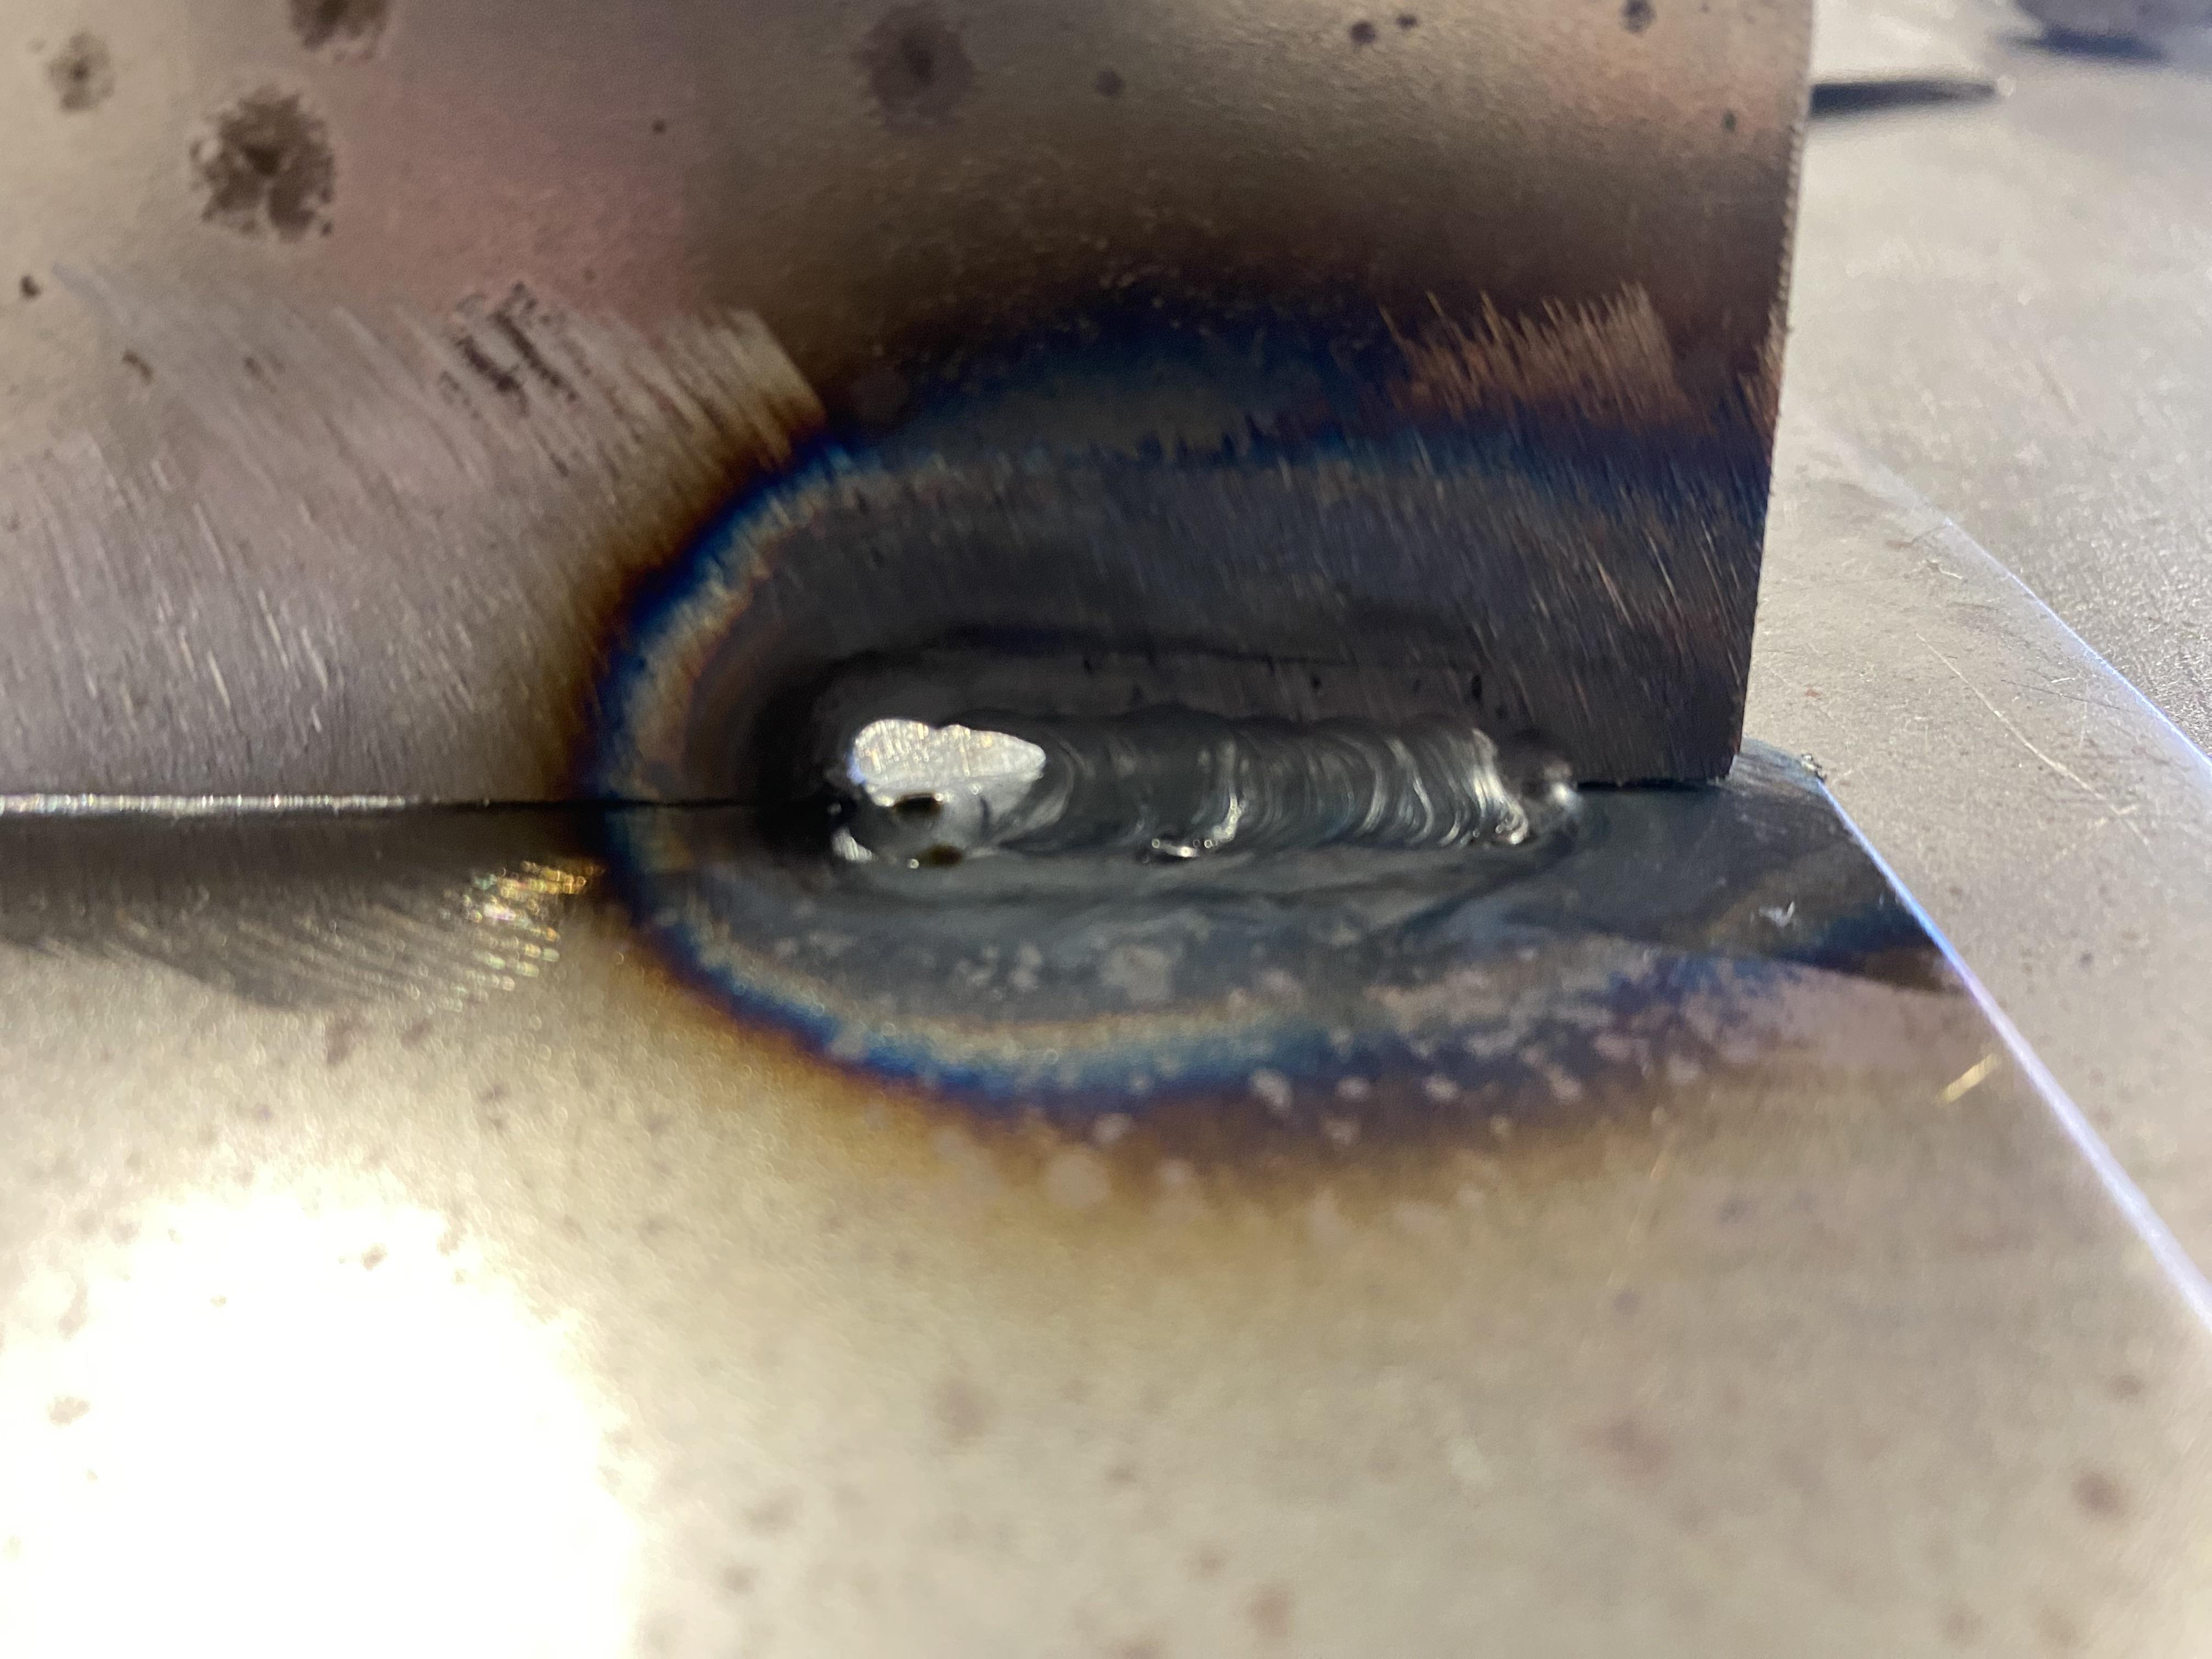


Ground Truth: Burn Through
Model Output: Burn Through



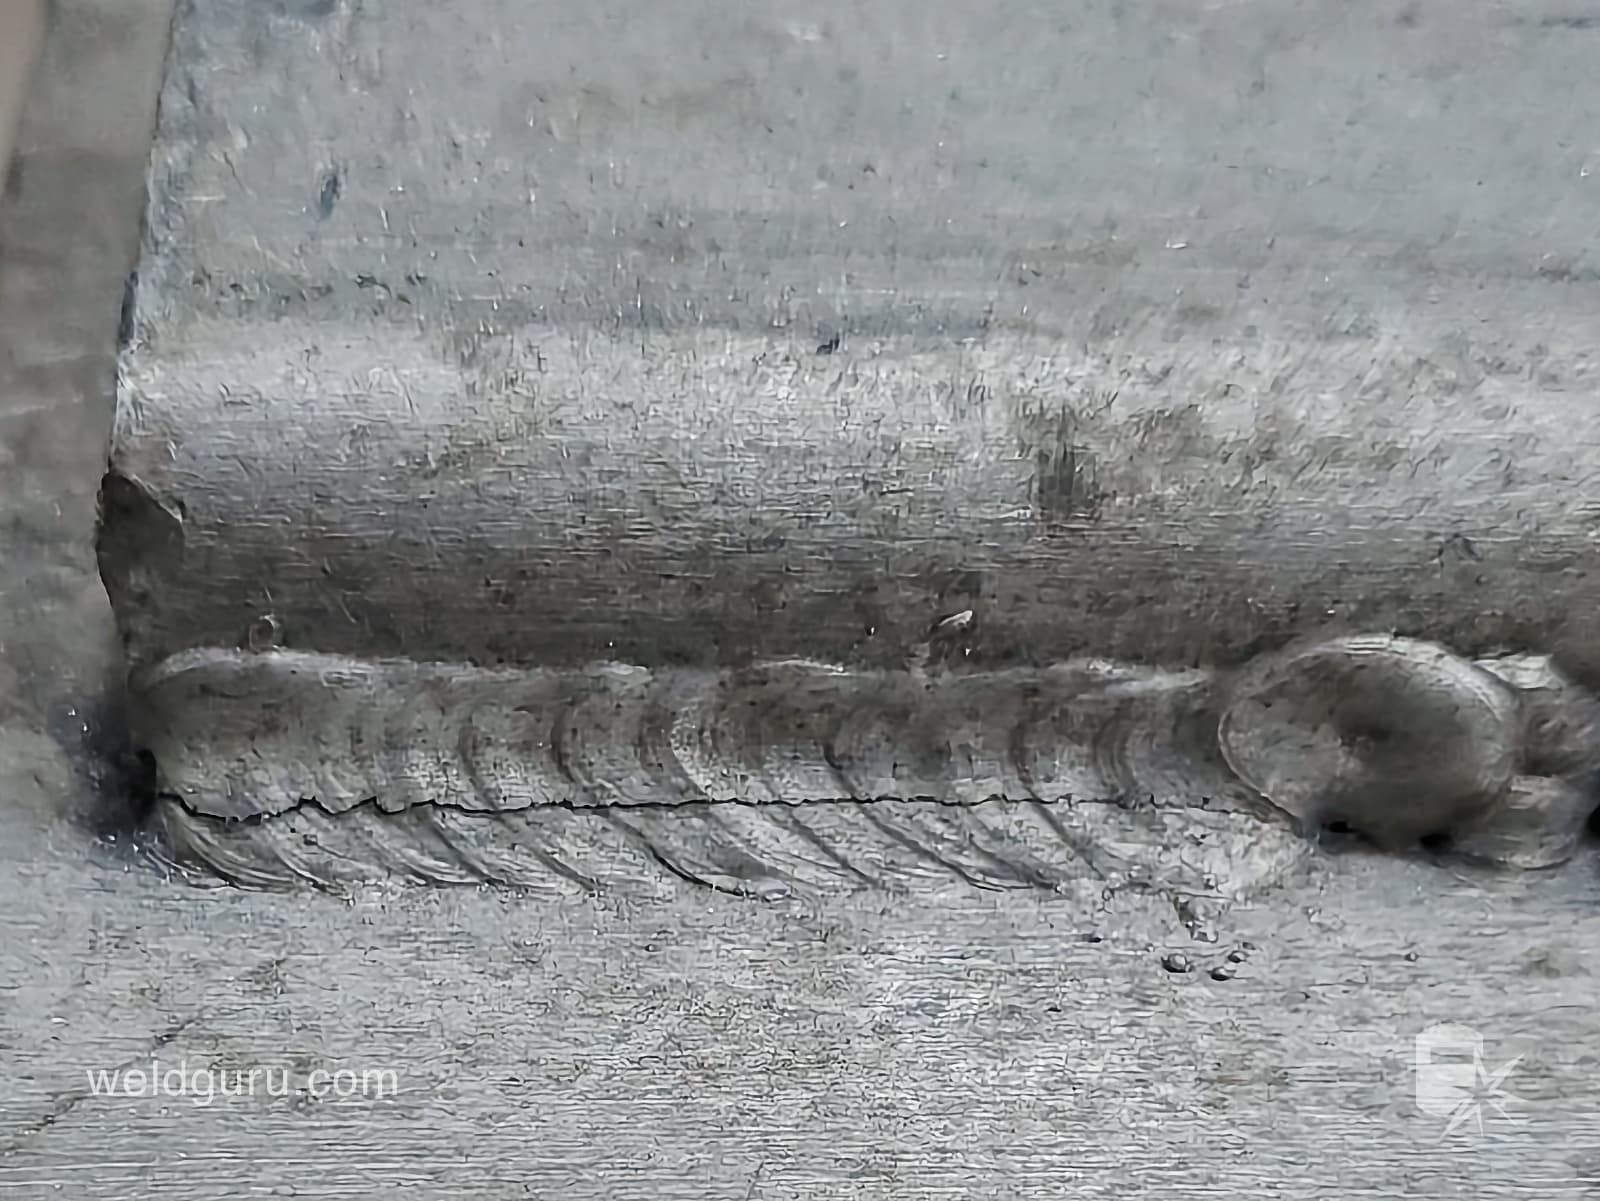


Ground Truth: Cracks
Model Output: Cracks



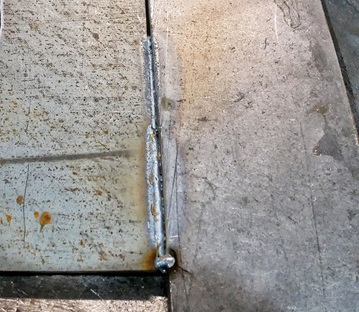


Ground Truth: Lack of Fusion
Model Output: Lack of Fusion



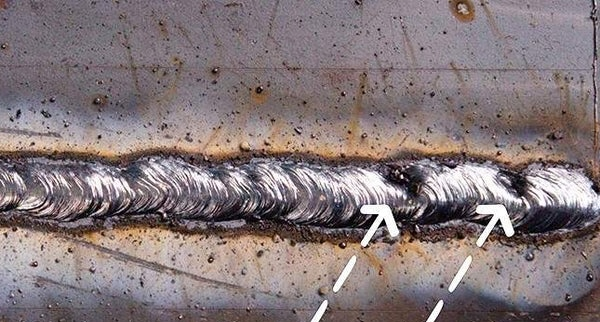


Ground Truth: Slag Inclusion
Model Output: Splatter



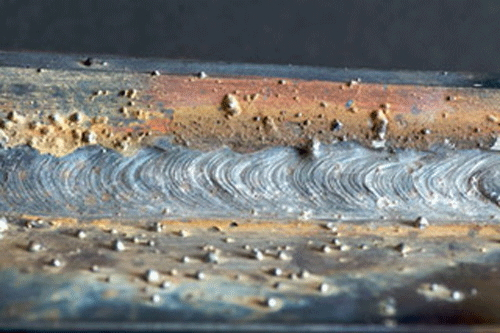


Ground Truth: Splatter
Model Output: Splatter



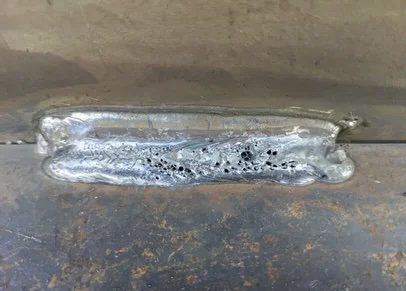


Ground Truth: Surface Porosity
Model Output: Surface Porosity



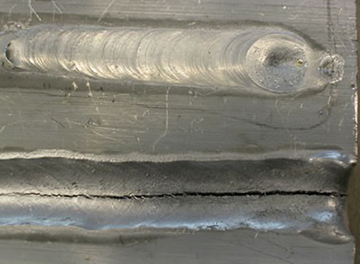


Ground Truth: Cracks
Model Output: Cracks



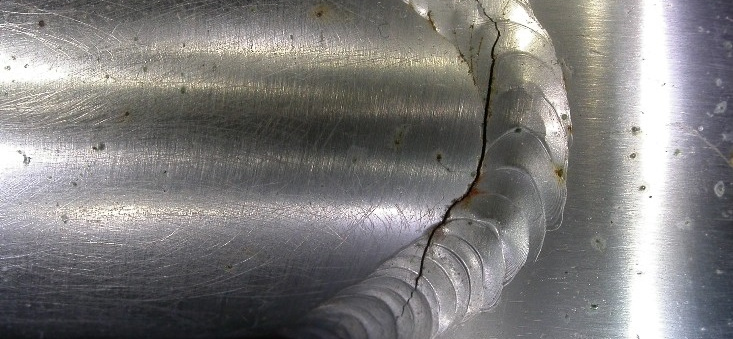


Ground Truth: Cracks
Model Output: Cracks



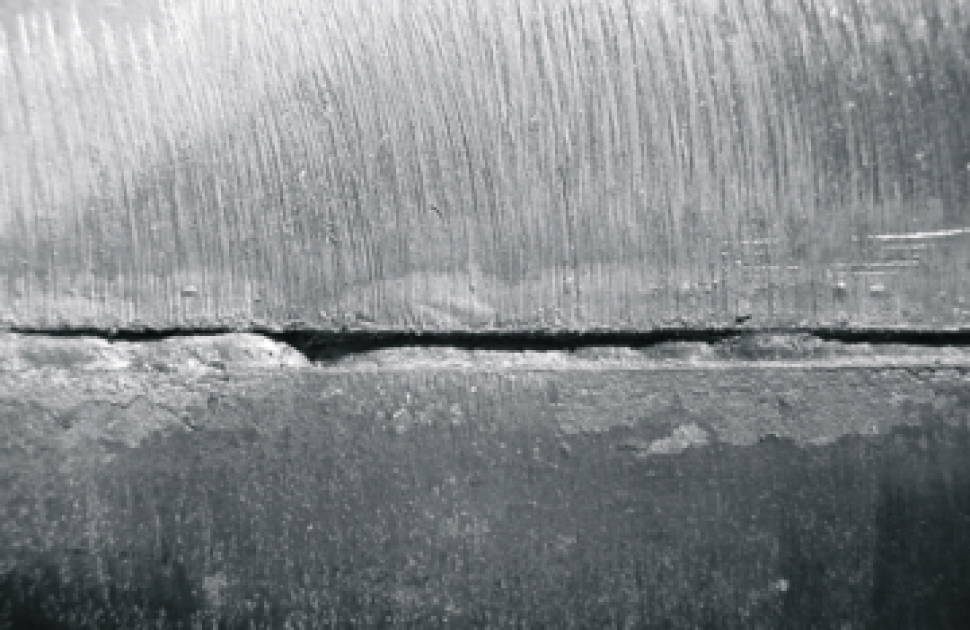


Ground Truth: Lack of Fusion
Model Output: Lack of Fusion



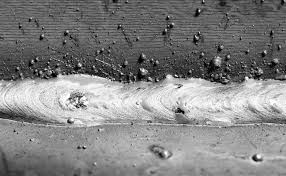


Ground Truth: Splatter
Model Output: Splatter



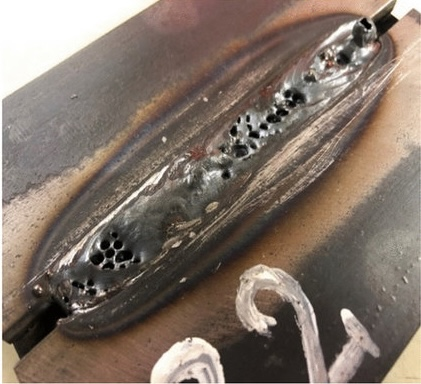


Ground Truth: Surface Porosity
Model Output: Surface Porosity

Overall Accuracy: 0.91



In [ ]:
#@title **ICL Image Classification**
test_labels = [
    "Burn Through",
    "Cracks",
    "Lack of Fusion",
    "Slag Inclusion",
    "Splatter",
    "Surface Porosity",
    "Cracks",
    "Cracks",
    "Lack of Fusion",
    "Splatter",
    "Surface Porosity"
    ]

def load_part(path):
    with open(path, "rb") as f:
        return types.Part.from_bytes(
            data=f.read(),
            mime_type="image/jpeg"
        )

train_paths = [f"intro_to_icl_data/industrial_defects/train{i}.jpg" for i in range(1, 10)]
train_labels = ["Cracks", "Surface Porosity", "Slag Inclusion", "Splatter", "Burn Through", "Lack of Fusion", "Splatter", "Slag Inclusion", "Surface Porosity", "Burn Through", "Burn Through"]

train_parts = [load_part(p) for p in train_paths]

def classify_image(label, index):
    test_path = f"intro_to_icl_data/industrial_defects/test{index}.jpg"
    test_part = load_part(test_path)

    contents = ["You are an expert in detecting industrial defects. "
                "By only using the provided examples, classify the defect.\n"]

    for i, (tlabel, tpart) in enumerate(zip(train_labels, train_parts)):
        contents.append(f"Example {i+1}: {tlabel}")
        contents.append(tpart)

    contents.extend([
        "What is the defect in the test image? Only return the label.",
        test_part,
    ])


    try:
      response = client.models.generate_content(
          model=model_name,
          contents=contents,
      )
    except Exception as e:
      print("Waiting 60 seconds for quota limit reset")
      time.sleep(60)
      response = client.models.generate_content(
          model="gemini-2.5-flash",
          contents=contents,
          config=types.GenerateContentConfig(
                thinking_config=types.ThinkingConfig(thinking_budget=0)
          )
      )

    return response.text.strip(), test_path

correct = 0
results = []
print("Starting Image Classification for Welding Defects\n")
for i, label in enumerate(test_labels, start=1):
    pred, path = classify_image(label, i)

    display(Image(filename=path, height = 300))

    print(f"\nGround Truth: {label}")
    print(f"Model Output: {pred}\n")

    is_correct = (pred.lower() == label.lower())

    results.append((label, pred, is_correct))
    correct += int(is_correct)

accuracy = correct / len(test_labels)
print(f"Overall Accuracy: {accuracy:.2f}\n")

This cell `Baseline SVM Model` implements the traditional machine-learning baseline used to compare against the in-context learning approaches. Rather than learning patterns directly from image pixels, this baseline relies on hand-crafted visual descriptors—specifically Histogram of Oriented Gradients (HOG)—which are then classified using a linear Support Vector Machine (SVM). The code loads the training images, converts them to grayscale, resizes each to 256×256, and extracts their HOG feature vectors. The same preprocessing steps are applied to the test set, ensuring a consistent feature representation. Once the features are assembled, a LinearSVC classifier is trained and evaluated on the same set of test images used by the ICL methods. The resulting accuracy provides a structured, feature-engineered benchmark to compare against the LLM’s prompt-based classification performance.

In [ ]:
#@title **Baseline SVM Model**
from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Load train data
X_train = []
y_train = []

for path, label in zip(train_paths, train_labels):
    img = imread(path)
    img = resize(img, (256, 256), anti_aliasing=True)
    img = rgb2gray(img)

    feats = hog(img, pixels_per_cell=(16,16), cells_per_block=(2,2))
    X_train.append(feats)
    y_train.append(label)

# Load test data
X_test = []
y_test = []

for i, label in enumerate(test_labels, start=1):
    img = imread(f"intro_to_icl_data/industrial_defects/test{i}.jpg")
    img = resize(img, (256, 256), anti_aliasing=True)
    img = rgb2gray(img)

    feats = hog(img, pixels_per_cell=(16,16), cells_per_block=(2,2))
    X_test.append(feats)
    y_test.append(label)

# Train classifier
clf = LinearSVC()
clf.fit(X_train, y_train)

# Predict
preds = clf.predict(X_test)
print("Baseline HOG+SVM Accuracy:", accuracy_score(y_test, preds))

Baseline HOG+SVM Accuracy: 0.2727272727272727


         Model Comparison Summary

ICL Accuracy:       0.909
Baseline Accuracy:  0.273

ICL Classification Report:
                  precision    recall  f1-score   support

    Burn Through       1.00      1.00      1.00         1
          Cracks       1.00      1.00      1.00         3
  Lack of Fusion       1.00      1.00      1.00         2
  Slag Inclusion       0.00      0.00      0.00         1
        Splatter       0.67      1.00      0.80         2
Surface Porosity       1.00      1.00      1.00         2

        accuracy                           0.91        11
       macro avg       0.78      0.83      0.80        11
    weighted avg       0.85      0.91      0.87        11

Baseline Classification Report:
                  precision    recall  f1-score   support

    Burn Through       0.00      0.00      0.00         1
          Cracks       1.00      0.33      0.50         3
  Lack of Fusion       0.00      0.00      0.00         2
  Slag Inclusion       0.00      0.00

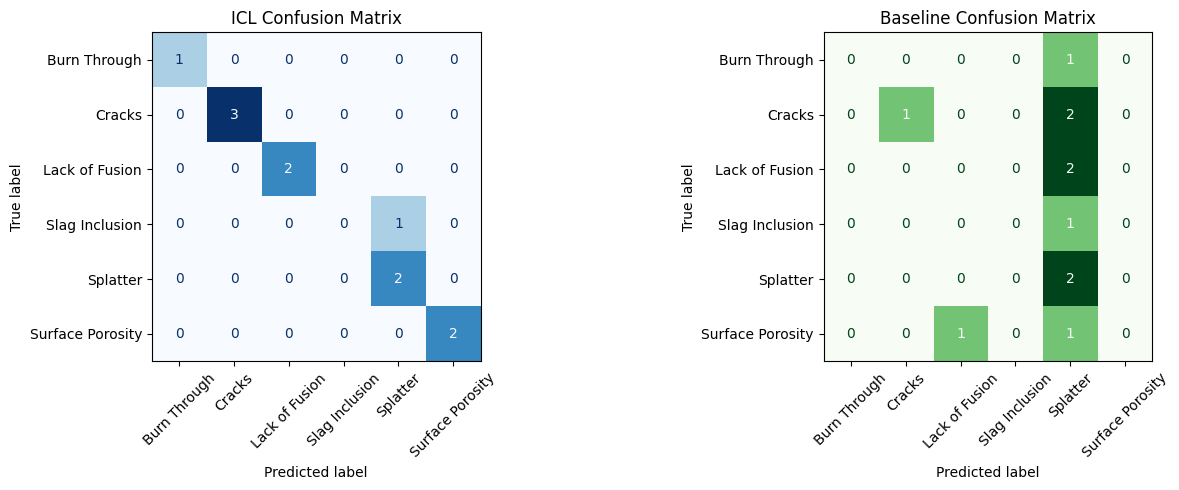

In [ ]:
#@title **ICL and Baseline SVM Comparison**
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ----------------------------------------------------
# Extract predictions from your existing ICL results
# results = [(label, pred, is_correct), ...]
icl_true = [r[0] for r in results]
icl_pred = [r[1] for r in results]

# ----------------------------------------------------
# Extract baseline predictions (already in 'preds')
baseline_pred = list(preds)
baseline_true = list(test_labels)   # Same ordering as test inputs

# ----------------------------------------------------
# Compute accuracies
icl_accuracy = sum(np.array(icl_true) == np.array(icl_pred)) / len(icl_true)
baseline_accuracy = sum(np.array(baseline_true) == np.array(baseline_pred)) / len(baseline_true)

print("===========================================")
print("         Model Comparison Summary")
print("===========================================\n")

print(f"ICL Accuracy:       {icl_accuracy:.3f}")
print(f"Baseline Accuracy:  {baseline_accuracy:.3f}\n")

print("ICL Classification Report:")
print(classification_report(icl_true, icl_pred, zero_division=0))

print("Baseline Classification Report:")
print(classification_report(baseline_true, baseline_pred, zero_division=0))

# ----------------------------------------------------
# Confusion Matrices (ICL and Baseline)
labels_sorted = sorted(list(set(test_labels)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ICL Confusion Matrix
cm_icl = confusion_matrix(icl_true, icl_pred, labels=labels_sorted)
disp_icl = ConfusionMatrixDisplay(confusion_matrix=cm_icl, display_labels=labels_sorted)
disp_icl.plot(ax=axes[0], xticks_rotation=45, cmap="Blues", colorbar=False)
axes[0].set_title("ICL Confusion Matrix")

# Baseline Confusion Matrix
cm_baseline = confusion_matrix(baseline_true, baseline_pred, labels=labels_sorted)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=labels_sorted)
disp_base.plot(ax=axes[1], xticks_rotation=45, cmap="Greens", colorbar=False)
axes[1].set_title("Baseline Confusion Matrix")

plt.tight_layout()
plt.show()

## **Summary**

This demo illustrates how LLMs can perform in-context learning (ICL) for multi-class image classification, using real weld defect imagery as the target domain. By supplying the model with a small set of annotated image–label pairs—covering six defect categories such as weld cracks, burn through, slag inclusion, weld splatter, lack of fusion, and surface porosity—we show that the model can infer subtle structural cues that distinguish one defect type from another. These cues include local texture disruptions, cavity patterns, shape irregularities, and characteristic weld-surface anomalies. Crucially, the model learns entirely from the examples embedded in the prompt: no fine-tuning, no gradient updates, and no specialized vision training occurs.

To contextualize performance, the ICL approach is compared against a traditional machine-learning baseline that must learn directly from pixel-level information. While the baseline relies on supervised training and engineered features, the LLM derives its classification behavior purely from pattern recognition using images and the prompt. When evaluated on unseen weld defect images, ICL consistently performs better than the baseline—demonstrating stronger generalization from just a few examples and outperforming the benchmark in overall accuracy. These results highlight the efficiency and adaptability of ICL for inspection-style tasks, especially when training data is scarce or rapid deployment is required.

## **Conclusion**

This demonstration shows that LLMs can successfully classify complex weld defects using only in-context visual examples, effectively acting as prompt-driven inspectors capable of recognizing defect signatures from minimal supervision. The ICL paradigm proves especially powerful in this setting: with only nine example images, the model generalizes to new, unseen weld defects more reliably than the supervised baseline, reflecting the model’s flexibility and its ability to internalize visual patterns without any training pipeline.

Compared to traditional approaches—which typically require substantial datasets, model tuning, and iterative optimization—the ICL method provides a fast, low-overhead alternative that can be adapted to new defect categories simply by revising the prompt. Together, the comparison between ICL and the baseline model demonstrates why LLMs are well-suited for rapid, lightweight visual classification tasks such as weld inspection, quality assurance, and defect triage, offering accurate and consistent performance with minimal setup and significantly reduced computational cost.